In [64]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

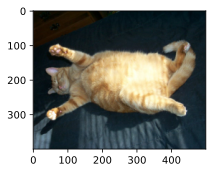

In [5]:
d2l.set_figsize()
img = d2l.Image.open('img/cat1.jpg')
d2l.plt.imshow(img)

In [7]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

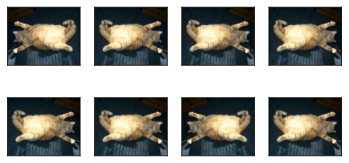

In [8]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

In [9]:
#fine-tuning
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [10]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

正在从http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip下载../data/hotdog.zip...


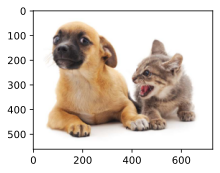

In [13]:
%matplotlib inline
import torch
from d2l import torch as d2l
d2l.set_figsize()
img = d2l.plt.imread('img/catdog.jpg')
d2l.plt.imshow(img)

In [20]:
A=torch.arange(16).resize(4,4)
print(A[:,0].shape)
print(A[:,1].shape)
print(A[:,2])

torch.Size([4])
torch.Size([4])
tensor([ 2,  6, 10, 14])


In [21]:
#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [23]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

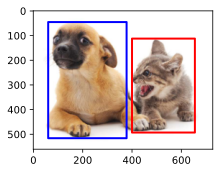

In [24]:
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

In [25]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 精简输出精度

In [7]:
#@save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    print("center_h: ",center_h.shape)
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    print("center_w: ",center_w.shape)
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    print("shift_y: ",shift_y.shape)
    print("shift_x: ",shift_x.shape)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    print("shift_y reshape(-1): ",shift_y.shape)
    print("shift_x reshape(-1): ",shift_x.shape)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)

    print(size_tensor * torch.sqrt(ratio_tensor[0]))
    print(sizes[0] * torch.sqrt(ratio_tensor[1:]))
    print("torch.cat: ",torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))))
    
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))* in_height / in_width  # 处理矩形输入
    
    print("W Shape: ",w,w.shape)

    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    print("h shape: ",h,h.shape)

    print("torch.stack shape: ",torch.stack((-w, -h, w, h)).shape)

    print("torch.stack().T  shape: ",torch.stack((-w, -h, w, h)).T.shape)
    print("in_height*in_width=",in_height*in_width)
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    print("anchor_manipulations: ",anchor_manipulations.shape)

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    print("output shape:" ,output)
    return output.unsqueeze(0)

In [8]:
img = d2l.plt.imread('img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728
center_h:  torch.Size([561])
center_w:  torch.Size([728])
shift_y:  torch.Size([561, 728])
shift_x:  torch.Size([561, 728])
shift_y reshape(-1):  torch.Size([408408])
shift_x reshape(-1):  torch.Size([408408])
tensor([0.75, 0.50, 0.25])
tensor([1.06, 0.53])
torch.cat:  tensor([0.75, 0.50, 0.25, 1.06, 0.53])
W Shape:  tensor([0.58, 0.39, 0.19, 0.82, 0.41]) torch.Size([5])
h shape:  tensor([0.75, 0.50, 0.25, 0.53, 1.06]) torch.Size([5])
torch.stack shape:  torch.Size([4, 5])
torch.stack().T  shape:  torch.Size([5, 4])
in_height*in_width= 408408
anchor_manipulations:  torch.Size([2042040, 4])
output shape: tensor([[-0.29, -0.37,  0.29,  0.38],
        [-0.19, -0.25,  0.19,  0.25],
        [-0.10, -0.12,  0.10,  0.13],
        ...,
        [ 0.90,  0.87,  1.10,  1.12],
        [ 0.59,  0.73,  1.41,  1.26],
        [ 0.79,  0.47,  1.20,  1.53]])


torch.Size([1, 2042040, 4])

生成锚框的方法

In [29]:

def multibox_prior(data,sizes,ratios):
    '''data [batch,channel,heith,width]
       sizes list type
       ratios list type
       output: [1,height*width*(len(sizes)*len(ratios)-1),4]
    '''
    in_height,in_width=data.shape[-2:]

    #设备的加速，缩放和宽高比个数
    device,num_sizes,num_ratios=data.device,len(sizes),len(ratios)

    boxes_per_pixel=num_ratios+num_sizes-1


    size_tensor=torch.tensor(sizes,device=device)
    ratio_tensor=torch.tensor(ratios,device=device)

    #每个像素是1*1的正方形，则中心点坐标为（0.5,0.5），所以要设置中心点（0.5,0.5）的偏移
    offset_h=0.5
    offset_w=0.5

    step_h=1.0/in_height
    step_w=1.0/in_width


    center_h=(torch.arange(in_height,device=device)+offset_h)*step_h
    center_w=(torch.arange(in_width,device=device)+offset_w)*step_w

    shift_y,shift_x=torch.meshgrid(center_h,center_w,indexing="ij")
    shift_x=shift_x.reshape(-1)
    shift_y=shift_y.reshape(-1)
    
    norm=torch.sqrt(torch.tensor(in_height)/torch.tensor(in_width))
 


    w_0=torch.cat((size_tensor*torch.sqrt(ratio_tensor[0]),size_tensor[0]*ratio_tensor[1:]))*norm
    h_0=torch.cat((size_tensor/torch.sqrt(ratio_tensor[0]),size_tensor[0]/torch.sqrt(ratio_tensor[1:])))/norm

    # w_0 = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
    #                sizes[0] * torch.sqrt(ratio_tensor[1:])))\
    #                * in_height / in_width  # 处理矩形输入
    # h_0 = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
    #                sizes[0] / torch.sqrt(ratio_tensor[1:])))


    anchor_manipulations=torch.stack((-w_0,-h_0,w_0,h_0)).T.repeat(in_height*in_width,1)/2

    out_grid=torch.stack([shift_x,shift_y,shift_x,shift_y],dim=1).repeat_interleave(boxes_per_pixel,dim=0)

    output=out_grid+anchor_manipulations

    return output.unsqueeze(0)

img = d2l.plt.imread('img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
print(Y.shape)
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

561 728
torch.Size([1, 2042040, 4])


tensor([0.01, 0.02, 0.67, 0.87])

In [30]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

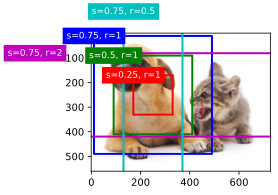

In [31]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

这个地方与d2l代码有出入，但是是这个版本比较严谨；

In [63]:
#@save
def box_iou(boxes1, boxes2):
    print("boxes1： ",boxes1)
    print("boxes2： ",boxes2)
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)

    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)

    print("areas1: ",areas1.shape)
    print("areas2: ",areas2.shape)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    print("boxes1 :",boxes1)
    print("boxes1[:,None,:2] ",boxes1[:,None,:2])
    print("boxes2[:,:2] ",boxes2[:,:2])

    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    print("inter_upperlefts: ",inter_upperlefts)
    print("inter_lowerrights: ",inter_lowerrights)

    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    print("jaccard:  ",jaccard.shape)
    print(jaccard)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [38]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

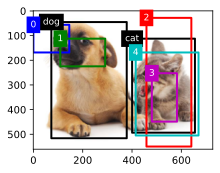

In [39]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [40]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

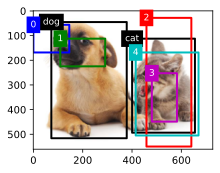

In [41]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [61]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

boxes1：  tensor([[0.00, 0.10, 0.20, 0.30],
        [0.15, 0.20, 0.40, 0.40],
        [0.63, 0.05, 0.88, 0.98],
        [0.66, 0.45, 0.80, 0.80],
        [0.57, 0.30, 0.92, 0.90]])
boxes2：  tensor([[0.10, 0.08, 0.52, 0.92],
        [0.55, 0.20, 0.90, 0.88]])
areas1:  torch.Size([5])
areas2:  torch.Size([2])
boxes1 : tensor([[0.00, 0.10, 0.20, 0.30],
        [0.15, 0.20, 0.40, 0.40],
        [0.63, 0.05, 0.88, 0.98],
        [0.66, 0.45, 0.80, 0.80],
        [0.57, 0.30, 0.92, 0.90]])
boxes1[:,None,:2]  tensor([[[0.00, 0.10]],

        [[0.15, 0.20]],

        [[0.63, 0.05]],

        [[0.66, 0.45]],

        [[0.57, 0.30]]])
boxes2[:,:2]  tensor([[0.10, 0.08],
        [0.55, 0.20]])
inter_upperlefts:  tensor([[[0.10, 0.10],
         [0.55, 0.20]],

        [[0.15, 0.20],
         [0.55, 0.20]],

        [[0.63, 0.08],
         [0.63, 0.20]],

        [[0.66, 0.45],
         [0.66, 0.45]],

        [[0.57, 0.30],
         [0.57, 0.30]]])
inter_lowerrights:  tensor([[[0.20, 0.30],
       